# Colorectal polyp segmentation #
The code below uses the CVC-ClinicDB public data set which consists of 612 images with corresponding segmentation masks. The dataset can be found here: https://www.kaggle.com/balraj98/cvcclinicdb?select=metadata.csv.

To run the code, put the original .tif files in the `/data/images` folder and the segmentation masks (ground truth) in the `/data/masks` folder.

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

from pathlib import Path
from functools import reduce
from collections import defaultdict
from sklearn.model_selection import StratifiedKFold, GroupKFold
from Losses import ComboLoss, dice_metric
from Split import StratifiedGroupKFold 

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import Sampler

import albumentations as albu
from albumentations.pytorch.transforms import ToTensor

print('torch.cuda.is_available():', torch.cuda.is_available())

torch.cuda.is_available(): True


In [2]:
try:
    get_ipython().__class_._name__
    from tqdm.notebook import tqdm
except:
    from tqdm import tqdm

In [3]:
DATA_DIR         = Path(f'data/')
TRAIN_IMG_DIR    = DATA_DIR/'images'
TRAIN_MASK_DIR   = DATA_DIR/'masks'
RLE_DF_PATH      = 'rle.csv'
KFOLD_PATH       = 'rle_kfold.csv'
TRAIN_BATCH_SIZE = 14
VALID_BATCH_SIZE = 14
USE_SAMPLER      = False
ENCODER          = 'se_resnext50_32x4d'
ENCODER_WEIGHTS  = 'imagenet'
CLASSES          = ['mask']
ACTIVATION       = None 
DEVICE           = 'cuda'
PRETRAINED_PATH  = '../data/bst_model512_fold2_0.9565.bin'
PRETRAINED       = False
LEARNING_RATE    = 2e-5
EPOCHS           = 40
LOSS_FN          = 'mixed'
CRITERION        = ComboLoss(**{'weights':{'bce':3, 'dice':1, 'focal':4}})
USE_CRIT         = True
TRAIN_MODEL      = True
EVALUATE         = True
FOLD_ID          = 2
IMG_SIZE         = 512

In [4]:
# The public datasets have more than 2 colors (due to gradients around the edges). Convert those colors to either black or white
def map_binary(mask):
    (threshold, black_and_white) = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    return black_and_white

In [5]:
# Run-length encode the segmentation masks
def run_length_encode(component):
    component = component.T.flatten()
    start = np.where(component[1:] > component[:-1])[0]+1
    end = np.where(component[:-1] > component[1:])[0]+1
    length = end-start
    rle = []
    for i in range(len(length)):
        if i == 0:
            rle.extend([start[0], length[0]])
        else:
            rle.extend([start[i]-end[i-1], length[i]])
    rle = ' '.join([str(r) for r in rle])
    return rle

In [6]:
def matplotlib_imshow(img, one_channel=False):
    fig,ax = plt.subplots(figsize=(10,6))
    ax.imshow(img.permute(1,2,0).numpy())

def visualize(**images):
    """PLot images in one row."""
    images = {k:v.numpy() for k,v in images.items() if isinstance(v, torch.Tensor)} #convert tensor to numpy 
    n = len(images)
    plt.figure(figsize=(16, 8))
    image, mask = images['image'], images['mask']
    plt.imshow(image.transpose(1,2,0), vmin=0, vmax=1)
    if mask.max()>0:
        plt.imshow(mask.squeeze(0), alpha=0.25)
    plt.show()

Convert segmentation masks to RLE (https://medium.com/analytics-vidhya/generating-masks-from-encoded-pixels-semantic-segmentation-18635e834ad0), put them in a dataframe and write to a CSV. This will create a dataframe that looks like this:

| ImageId | EncodedPixels               |
|---------|-----------------------------|
| 154     | 40748, 6, 281, 9, 277, 16   |
| 155     | 43614, 13, 268, 23, 263, 26 |

Doesn't have to be ran every single time.

In [7]:
data = {}
image_ids = []
encoded_pixels = []
file_paths = []
mask_paths = []

for file in tqdm(list(TRAIN_MASK_DIR.glob('**/*.tif'))):
    source = str(file.parent).split(os.sep)[-1]
    image_id = f'{source}/{file.stem}'
    image_path = file.parent.parent.parent.joinpath('images', source, file.name)
    
    img = cv2.imread(str(file), 0)
    black_and_white = map_binary(img)
    rle_encoded = run_length_encode(black_and_white)
    image_ids.append(image_id)
    encoded_pixels.append(rle_encoded)
    file_paths.append(file)
    mask_paths.append(image_path)

data['ImageId'] = image_ids
data['EncodedPixels'] = encoded_pixels
rle_df = pd.DataFrame(data, columns=['ImageId', 'EncodedPixels'])
rle_df.to_csv(RLE_DF_PATH, index=False)

100%|████████████████████████████████████████████████████████████████████████████████| 808/808 [00:09<00:00, 84.30it/s]


In [8]:
rle_tmp_df       = pd.read_csv(RLE_DF_PATH, names=['ImageId', 'EncodedPixels'], skiprows=1)
cvc_metadata_df  = pd.read_csv('cvc-metadata.csv')
etis_metadata_df = pd.read_csv('etis-metadata.csv')
dfs              = [rle_tmp_df, cvc_metadata_df, etis_metadata_df]
RLE_DF           = reduce(lambda left, right: pd.merge(left, right, how='outer', on='ImageId'), dfs)
RLE_DF['sequence_id'] = RLE_DF['sequence_id_x'].combine_first(RLE_DF['sequence_id_y'])
RLE_DF = RLE_DF.drop(columns=['sequence_id_x', 'sequence_id_y'])

RLE_DF['has_mask'] = 0
RLE_DF.loc[RLE_DF.EncodedPixels != '-1', 'has_mask'] = 1
RLE_DF['kfold'] = -1

gkf = GroupKFold(n_splits=3)
gkf.get_n_splits(RLE_DF.ImageId, RLE_DF.has_mask, RLE_DF.sequence_id)

for fold, (train_index, test_index) in enumerate(gkf.split(RLE_DF.ImageId, RLE_DF.has_mask, RLE_DF.sequence_id)):
    RLE_DF.loc[test_index, 'kfold'] = fold
    
RLE_DF.to_csv(KFOLD_PATH, index=False)

RLE_DF.head()

,ImageId,EncodedPixels,sequence_id,has_mask,kfold
0,cvc/1,11677 54 1 8 1 14 210 53 2 8 2 1 1 1 1 10 208 ...,cvc/1,1,1
1,cvc/10,11575 9 10 10 258 35 252 75 212 142 22 17 106 ...,cvc/1,1,1
2,cvc/100,19728 9 274 19 263 28 256 35 251 38 247 43 243...,cvc/5,1,1
3,cvc/101,47679 11 274 18 268 26 260 31 255 38 249 41 24...,cvc/5,1,1
4,cvc/102,47951 24 262 27 259 32 255 35 252 37 250 39 24...,cvc/5,1,1


In [9]:
DF = pd.read_csv(KFOLD_PATH)
TRAIN_DF = DF.query(f'kfold!={FOLD_ID}').reset_index(drop=True)
VAL_DF = DF.query(f'kfold=={FOLD_ID}').reset_index(drop=True)

In [10]:
class Dataset():
    def __init__(self, rle_df, image_base_dir, masks_base_dir, augmentation=None):
        self.df             = rle_df
        self.image_base_dir = image_base_dir
        self.masks_base_dir = masks_base_dir
        self.image_ids      = rle_df.ImageId.values
        self.augmentation   = augmentation
    
    def __getitem__(self, i):
        image_id  = self.image_ids[i]
        img_path  = os.path.join(str(self.image_base_dir), str(image_id)+'.tif') 
        mask_path = os.path.join(str(self.masks_base_dir), str(image_id)+'.tif')
        image     = cv2.imread(img_path, 1)
        mask      = map_binary(cv2.imread(mask_path, 0))     
        
        # apply augmentations
        if self.augmentation:
            sample = {"image": image, "mask": mask}
            sample = self.augmentation(**sample)
            image, mask = sample['image'], sample['mask']

        return {
            'image': image, 
            'mask' : mask
        }
        
    def __len__(self):
        return len(self.image_ids)

In [11]:
train_transformations = albu.Compose([
    albu.SmallestMaxSize(max_size=288),
    albu.CenterCrop(288, 288),
    albu.HorizontalFlip(),
    albu.VerticalFlip(),
    albu.Rotate(),
    albu.Normalize(),
    ToTensor()
])

test_transformations = albu.Compose([
    albu.SmallestMaxSize(max_size=288),
    albu.CenterCrop(288, 288),
    albu.Normalize(),
    ToTensor()
])

In [12]:
train_dataset = Dataset(TRAIN_DF, TRAIN_IMG_DIR, TRAIN_MASK_DIR, train_transformations)
test_dataset = Dataset(VAL_DF, TRAIN_IMG_DIR, TRAIN_MASK_DIR, test_transformations)

In [13]:
image, mask = train_dataset[538]['image'], train_dataset[538]['mask']
image.shape, mask.shape

(torch.Size([3, 288, 288]), torch.Size([1, 288, 288]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


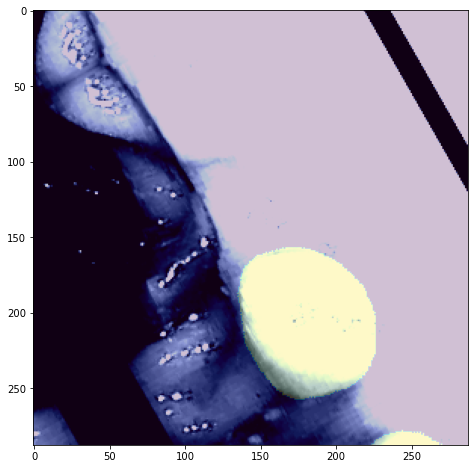

In [14]:
visualize(**train_dataset[2])

In [15]:
class PolypSampler(Sampler):
    def __init__(self, train_df, positive_perc=0.8):
        assert positive_perc > 0, 'percentage of positive polyp images must be greater than zero'
        self.train_df = train_df
        self.positive_perc = positive_perc
        self.positive_idxs = self.train_df.query('has_mask==1').index.values
        self.negative_idxs = self.train_df.query('has_mask!=1').index.values
        self.n_positive = len(self.positive_idxs)
        self.n_negative = int(self.n_positive * (1 - self.positive_perc) / self.positive_perc)
        
    def __iter__(self):
        negative_sample = np.random.choice(self.negative_idxs, size=self.n_negative)
        shuffled = np.random.permutation(np.hstack((negative_sample, self.positive_idxs)))
        return iter(shuffled.tolist())

    def __len__(self):
        return self.n_positive + self.n_negative
    
SAMPLER = PolypSampler(TRAIN_DF, positive_perc=1)

In [16]:
train_dataloader = DataLoader(train_dataset, TRAIN_BATCH_SIZE, 
                              shuffle=True if not USE_SAMPLER else False, 
                              num_workers=0, 
                              sampler=SAMPLER if USE_SAMPLER else None)
val_dataloader   = DataLoader(test_dataset, VALID_BATCH_SIZE, shuffle=False, num_workers=0)

In [17]:
images, masks = next(iter(train_dataloader))['image'], next(iter(train_dataloader))['mask']
images.shape, masks.shape

(torch.Size([14, 3, 288, 288]), torch.Size([14, 1, 288, 288]))

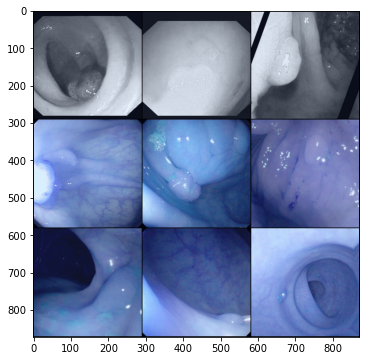

In [18]:
img_grid = torchvision.utils.make_grid(images[:9], nrow=3, normalize=True)
matplotlib_imshow(img_grid)

In [19]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

In [20]:
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()

In [21]:
class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [22]:
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

In [23]:
class EarlyStopping:
    def __init__(self, patience=7, mode="max", delta=0.0001):
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        if self.mode == "min":
            self.val_score = np.Inf
        else:
            self.val_score = -np.Inf

    def __call__(self, epoch_score, model, model_path):
        if self.mode == "min":
            score = -1.0 * epoch_score
        else:
            score = np.copy(epoch_score)

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(
                "EarlyStopping counter: {} out of {}".format(
                    self.counter, self.patience
                )
            )
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
            self.counter = 0

    def save_checkpoint(self, epoch_score, model, model_path):
        model_path = Path(model_path)
        parent = model_path.parent
        os.makedirs(parent, exist_ok=True)
        if epoch_score not in [-np.inf, np.inf, -np.nan, np.nan]:
            print(
                "Validation score improved ({} --> {}). Model saved at at {}!".format(
                    self.val_score, epoch_score, model_path
                )
            )
            torch.save(model.state_dict(), model_path)
        self.val_score = epoch_score

In [24]:
class AverageMeter:
    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [25]:
def train_one_epoch(train_loader, model, optimizer, loss_fn, accumulation_steps=1, device='cuda'):
    losses = AverageMeter()
    model = model.to(device)
    model.train()
    if accumulation_steps > 1: 
        optimizer.zero_grad()
    tk0 = tqdm(train_loader, total=len(train_loader))
    for b_idx, data in enumerate(tk0):
        for key, value in data.items():
            data[key] = value.to(device)
        if accumulation_steps == 1 and b_idx == 0:
            optimizer.zero_grad()
        out  = model(data['image'])
        loss = loss_fn(out, data['mask'])
        with torch.set_grad_enabled(True):
            loss.backward()
            if (b_idx + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
        losses.update(loss.item(), train_loader.batch_size)
        tk0.set_postfix(loss=losses.avg, learning_rate=optimizer.param_groups[0]['lr'])
    return losses.avg

In [26]:
def acc_metric(input, target):
    inp = torch.where(input>0.5, torch.tensor(1, device='cuda'), torch.tensor(0, device='cuda'))
    acc = (inp.squeeze(1) == target).float().mean()
    return acc

In [27]:
def metric(probability, truth, threshold=0.5, reduction='none'):
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)

        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice

In [28]:
def evaluate(valid_loader, model, device='cuda', metric=dice_metric):
    losses = AverageMeter()
    model = model.to(device)
    model.eval()
    tk0 = tqdm(valid_loader, total=len(valid_loader))
    with torch.no_grad():
        for b_idx, data in enumerate(tk0):
            for key, value in data.items():
                data[key] = value.to(device)
            out   = model(data['image'])
            out   = torch.sigmoid(out)
            dice  = metric(out, data['mask']).cpu()
            losses.update(dice.mean().item(), valid_loader.batch_size)
            tk0.set_postfix(dice_score=losses.avg)
    return losses.avg

In [29]:
if PRETRAINED: 
    model.load_state_dict(torch.load(PRETRAINED_PATH))

In [30]:
optimizer = torch.optim.Adam(model.parameters(), lr= LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[3,5,6,7,8,9,10,11,13,15], gamma=0.75)

In [31]:
criterion = MixedLoss(10.0, 2.0) if not USE_CRIT else CRITERION 
es = EarlyStopping(patience=10, mode='max')

In [32]:
criterion

ComboLoss(
  (bce): StableBCELoss()
  (dice): DiceLoss()
  (jaccard): JaccardLoss()
  (lovasz): LovaszLoss()
  (lovasz_sigmoid): LovaszLossSigmoid()
  (focal): FocalLoss2d()
)

In [33]:
if TRAIN_MODEL:
    for epoch in range(EPOCHS):
        loss = train_one_epoch(train_dataloader, model, optimizer, criterion)
        dice = evaluate(val_dataloader, model, metric=metric)
        scheduler.step()
        print(f"EPOCH: {epoch}, TRAIN LOSS: {loss}, VAL DICE: {dice}")
        es(dice, model, model_path=f"../data/bst_model{IMG_SIZE}_fold{FOLD_ID}_{np.round(dice,4)}.bin")
        best_model = f"../data/bst_model{IMG_SIZE}__fold{FOLD_ID}_{np.round(es.best_score,4)}.bin"
        if es.early_stop:
            print('\n\n -------------- EARLY STOPPING -------------- \n\n')
            break
if EVALUATE:
    valid_score = evaluate(val_dataloader, model, metric=metric)
    print(f"Valid dice score: {valid_score}")

100%|████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.10it/s, dice_score=0.172]


EPOCH: 0, TRAIN LOSS: 3.6600358180510693, VAL DICE: 0.17232888769358395
Validation score improved (-inf --> 0.17232888769358395). Model saved at at ..\data\bst_model512_fold2_0.1723.bin!


  0%|                                                                                           | 0/39 [00:00<?, ?it/s]

EPOCH: 1, TRAIN LOSS: 3.3412187771919446, VAL DICE: 0.16660448256880045
EarlyStopping counter: 1 out of 10


100%|████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.69it/s, dice_score=0.309]


EPOCH: 2, TRAIN LOSS: 3.091251654502673, VAL DICE: 0.30853562979027627
Validation score improved (0.17232888769358395 --> 0.30853562979027627). Model saved at at ..\data\bst_model512_fold2_0.3085.bin!


100%|████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.79it/s, dice_score=0.355]


EPOCH: 3, TRAIN LOSS: 2.8266088534624147, VAL DICE: 0.3554387727752328
Validation score improved (0.30853562979027627 --> 0.3554387727752328). Model saved at at ..\data\bst_model512_fold2_0.3554.bin!


100%|████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.75it/s, dice_score=0.397]


EPOCH: 4, TRAIN LOSS: 2.599595124904926, VAL DICE: 0.3967867687344551
Validation score improved (0.3554387727752328 --> 0.3967867687344551). Model saved at at ..\data\bst_model512_fold2_0.3968.bin!


100%|████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.84it/s, dice_score=0.427]


EPOCH: 5, TRAIN LOSS: 2.4371011501703506, VAL DICE: 0.426609131321311
Validation score improved (0.3967867687344551 --> 0.426609131321311). Model saved at at ..\data\bst_model512_fold2_0.4266.bin!


100%|████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.12it/s, dice_score=0.446]


EPOCH: 6, TRAIN LOSS: 2.320062661782289, VAL DICE: 0.44649437479674814
Validation score improved (0.426609131321311 --> 0.44649437479674814). Model saved at at ..\data\bst_model512_fold2_0.4465.bin!


100%|████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.54it/s, dice_score=0.465]


EPOCH: 7, TRAIN LOSS: 2.2285927320138, VAL DICE: 0.4651846427470446
Validation score improved (0.44649437479674814 --> 0.4651846427470446). Model saved at at ..\data\bst_model512_fold2_0.4652.bin!


100%|████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.53it/s, dice_score=0.476]


EPOCH: 8, TRAIN LOSS: 2.1863638865642057, VAL DICE: 0.4760024677962065
Validation score improved (0.4651846427470446 --> 0.4760024677962065). Model saved at at ..\data\bst_model512_fold2_0.476.bin!


100%|█████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.39it/s, dice_score=0.48]


EPOCH: 9, TRAIN LOSS: 2.1296414045187144, VAL DICE: 0.4798524770885706
Validation score improved (0.4760024677962065 --> 0.4798524770885706). Model saved at at ..\data\bst_model512_fold2_0.4799.bin!


100%|████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.06it/s, dice_score=0.488]


EPOCH: 10, TRAIN LOSS: 2.1203061189406958, VAL DICE: 0.48775905817747117
Validation score improved (0.4798524770885706 --> 0.48775905817747117). Model saved at at ..\data\bst_model512_fold2_0.4878.bin!


  0%|                                                                                           | 0/39 [00:00<?, ?it/s]

EPOCH: 11, TRAIN LOSS: 2.116249280098157, VAL DICE: 0.48691172040998937
EarlyStopping counter: 1 out of 10


  0%|                                                                                           | 0/39 [00:00<?, ?it/s]

EPOCH: 12, TRAIN LOSS: 2.1072193659268894, VAL DICE: 0.4896679647266865
Validation score improved (0.48775905817747117 --> 0.4896679647266865). Model saved at at ..\data\bst_model512_fold2_0.4897.bin!


100%|████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.72it/s, dice_score=0.494]


EPOCH: 13, TRAIN LOSS: 2.0725482060359073, VAL DICE: 0.49423650540411473
Validation score improved (0.4896679647266865 --> 0.49423650540411473). Model saved at at ..\data\bst_model512_fold2_0.4942.bin!


  0%|                                                                                           | 0/39 [00:00<?, ?it/s]

EPOCH: 14, TRAIN LOSS: 2.0875797546826877, VAL DICE: 0.49349969923496245
EarlyStopping counter: 1 out of 10


100%|████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.64it/s, dice_score=0.503]


EPOCH: 15, TRAIN LOSS: 2.076159571989989, VAL DICE: 0.5029487416148186
Validation score improved (0.49423650540411473 --> 0.5029487416148186). Model saved at at ..\data\bst_model512_fold2_0.5029.bin!


  0%|                                                                                           | 0/39 [00:00<?, ?it/s]

EPOCH: 16, TRAIN LOSS: 2.065207349948394, VAL DICE: 0.499380586668849
EarlyStopping counter: 1 out of 10


  0%|                                                                                           | 0/39 [00:00<?, ?it/s]

EPOCH: 17, TRAIN LOSS: 2.0346835118073683, VAL DICE: 0.4990942530333996
EarlyStopping counter: 2 out of 10


  0%|                                                                                           | 0/39 [00:00<?, ?it/s]

EPOCH: 18, TRAIN LOSS: 2.026577258721376, VAL DICE: 0.49985447004437444
EarlyStopping counter: 3 out of 10


100%|████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.59it/s, dice_score=0.504]


EPOCH: 19, TRAIN LOSS: 2.026866445174584, VAL DICE: 0.5042450599372387
Validation score improved (0.5029487416148186 --> 0.5042450599372387). Model saved at at ..\data\bst_model512_fold2_0.5042.bin!


  0%|                                                                                           | 0/39 [00:00<?, ?it/s]

EPOCH: 20, TRAIN LOSS: 2.0368520479935865, VAL DICE: 0.502362709492445
EarlyStopping counter: 1 out of 10


  0%|                                                                                           | 0/39 [00:00<?, ?it/s]

EPOCH: 21, TRAIN LOSS: 2.019074898499709, VAL DICE: 0.5060879766941071
Validation score improved (0.5042450599372387 --> 0.5060879766941071). Model saved at at ..\data\bst_model512_fold2_0.5061.bin!


  0%|                                                                                           | 0/39 [00:00<?, ?it/s]

EPOCH: 22, TRAIN LOSS: 1.9948737499041436, VAL DICE: 0.5057025015354156
EarlyStopping counter: 1 out of 10


  0%|                                                                                           | 0/39 [00:00<?, ?it/s]

EPOCH: 23, TRAIN LOSS: 1.9987902916394746, VAL DICE: 0.5062465123832226
Validation score improved (0.5060879766941071 --> 0.5062465123832226). Model saved at at ..\data\bst_model512_fold2_0.5062.bin!


  0%|                                                                                           | 0/39 [00:00<?, ?it/s]

EPOCH: 24, TRAIN LOSS: 1.9718493803953514, VAL DICE: 0.503838985413313
EarlyStopping counter: 1 out of 10


  0%|                                                                                           | 0/39 [00:00<?, ?it/s]

EPOCH: 25, TRAIN LOSS: 1.986130463771331, VAL DICE: 0.5074792474508285
Validation score improved (0.5062465123832226 --> 0.5074792474508285). Model saved at at ..\data\bst_model512_fold2_0.5075.bin!


  0%|                                                                                           | 0/39 [00:00<?, ?it/s]

EPOCH: 26, TRAIN LOSS: 1.9874276564671443, VAL DICE: 0.5097566589713096
Validation score improved (0.5074792474508285 --> 0.5097566589713096). Model saved at at ..\data\bst_model512_fold2_0.5098.bin!


  0%|                                                                                           | 0/39 [00:00<?, ?it/s]

EPOCH: 27, TRAIN LOSS: 1.955356423671429, VAL DICE: 0.5082043536007405
EarlyStopping counter: 1 out of 10


  0%|                                                                                           | 0/39 [00:00<?, ?it/s]

EPOCH: 28, TRAIN LOSS: 1.9579416880240808, VAL DICE: 0.5097039468586445
EarlyStopping counter: 2 out of 10


100%|████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.60it/s, dice_score=0.514]


EPOCH: 29, TRAIN LOSS: 1.9821467093932323, VAL DICE: 0.5139382071793079
Validation score improved (0.5097566589713096 --> 0.5139382071793079). Model saved at at ..\data\bst_model512_fold2_0.5139.bin!


  0%|                                                                                           | 0/39 [00:00<?, ?it/s]

EPOCH: 30, TRAIN LOSS: 1.9467922235146546, VAL DICE: 0.515957647562027
Validation score improved (0.5139382071793079 --> 0.515957647562027). Model saved at at ..\data\bst_model512_fold2_0.516.bin!


  0%|                                                                                           | 0/39 [00:00<?, ?it/s]

EPOCH: 31, TRAIN LOSS: 1.9662266266651642, VAL DICE: 0.5139787331223488
EarlyStopping counter: 1 out of 10


  0%|                                                                                           | 0/39 [00:00<?, ?it/s]

EPOCH: 32, TRAIN LOSS: 1.9540707423136785, VAL DICE: 0.5128035083413124
EarlyStopping counter: 2 out of 10


100%|████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.65it/s, dice_score=0.517]


EPOCH: 33, TRAIN LOSS: 1.9467536149880824, VAL DICE: 0.5167269200086594
Validation score improved (0.515957647562027 --> 0.5167269200086594). Model saved at at ..\data\bst_model512_fold2_0.5167.bin!


100%|████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.65it/s, dice_score=0.518]


EPOCH: 34, TRAIN LOSS: 1.9182266333164313, VAL DICE: 0.5177913248538971
Validation score improved (0.5167269200086594 --> 0.5177913248538971). Model saved at at ..\data\bst_model512_fold2_0.5178.bin!


  0%|                                                                                           | 0/39 [00:00<?, ?it/s]

EPOCH: 35, TRAIN LOSS: 1.925473167346074, VAL DICE: 0.516651163995266
EarlyStopping counter: 1 out of 10


  0%|                                                                                           | 0/39 [00:00<?, ?it/s]

EPOCH: 36, TRAIN LOSS: 1.9025765260060628, VAL DICE: 0.5182515665888786
Validation score improved (0.5177913248538971 --> 0.5182515665888786). Model saved at at ..\data\bst_model512_fold2_0.5183.bin!


100%|████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.65it/s, dice_score=0.524]


EPOCH: 37, TRAIN LOSS: 1.900493426200671, VAL DICE: 0.5242408633232116
Validation score improved (0.5182515665888786 --> 0.5242408633232116). Model saved at at ..\data\bst_model512_fold2_0.5242.bin!


100%|████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.72it/s, dice_score=0.524]


EPOCH: 38, TRAIN LOSS: 1.9051827956468632, VAL DICE: 0.5243560038506985
Validation score improved (0.5242408633232116 --> 0.5243560038506985). Model saved at at ..\data\bst_model512_fold2_0.5244.bin!


  5%|███▎                                                             | 1/20 [00:00<00:02,  7.89it/s, dice_score=0.705]

EPOCH: 39, TRAIN LOSS: 1.8953879552009778, VAL DICE: 0.5230811096727848
EarlyStopping counter: 1 out of 10


100%|████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.60it/s, dice_score=0.523]

Valid dice score: 0.5230811096727848
